In [1]:
import pandas as pd
import numpy as np
import calendar
from time import time
from datetime import datetime
import re 
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import log_loss, accuracy_score, classification_report
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_train = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")
data_train_orig = pd.read_csv("train.csv").replace("MENS WEAR","MENSWEAR")

In [3]:
dept_list = sorted(list(data_train.DepartmentDescription.dropna().unique()))

In [4]:
weekdays = list(calendar.day_name)
dept_list_sum = dict.fromkeys(dept_list, np.sum)
weekday_dict = dict.fromkeys(weekdays, np.max)
feature_dict = {"TripType": np.max, 'NumItems': np.sum, 'Return': np.max}
feature_dict = {**feature_dict, **weekday_dict, **dept_list_sum}

In [5]:
def transform_data(data):
    dummies = pd.get_dummies(data.Weekday)
    data[dummies.columns] = dummies
    
    dummies = pd.get_dummies(data.DepartmentDescription)
    dummies = dummies.apply(lambda x: x*data["ScanCount"])
    data[dummies.columns] = dummies 

    data.loc[data.ScanCount < 0, 'Return'] = 1
    data.loc[data.Return != 1, 'Return'] = 0
    
    data = data.rename(columns={"ScanCount":"NumItems"})
    
    grouped = data.groupby("VisitNumber")
    grouped = grouped.aggregate(feature_dict)
    data = grouped[["TripType", "NumItems", "Return"] + weekdays + dept_list]

    return data

In [6]:
data_new = transform_data(data_train)

In [7]:
def add_category_counts(data):
    alist = []
    for array in np.asarray(data.loc[:, dept_list[0]:]):
        count = 0
        count = sum(x > 0 for x in array)
        alist.append(count)
    cat_counts = pd.DataFrame(alist)
    cat_counts = cat_counts.rename(columns={0:"CategoryCount"})
    cat_counts = cat_counts.set_index(data.index)
    data.insert(3, 'CategoryCounts', cat_counts)
    return data

In [8]:
data_add_cat = add_category_counts(data_new)

In [11]:
def fineline_dummies(data):
    fln_ranks = data.FinelineNumber.value_counts()
    fln_ranks = fln_ranks[fln_ranks > 500]
    flns_selected = list(fln_ranks.index)
    dummies = pd.get_dummies(data.FinelineNumber)
    dummies = dummies[flns_selected]
    dummies.columns = ['fln_'+str(col) for col in dummies.columns]
    dummies = pd.concat([dummies, data.VisitNumber], axis=1)
    dummies = dummies.groupby("VisitNumber")
    dummies = dummies.aggregate(np.sum)
    return dummies

In [13]:
fln_dummies = fineline_dummies(data_train)

In [14]:
fln_dummies.head()

,fln_5501.0,fln_1508.0,fln_135.0,fln_808.0,fln_0.0,fln_9546.0,fln_1407.0,fln_4606.0,fln_115.0,fln_203.0,...,fln_805.0,fln_3704.0,fln_4500.0,fln_1352.0,fln_3175.0,fln_2352.0,fln_2804.0,fln_1009.0,fln_10.0,fln_7557.0
VisitNumber,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
9,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
data_add_fln = data_add_cat.join(fln_dummies)

In [16]:
data_add_fln.columns

Index(['TripType', 'NumItems', 'Return', 'CategoryCounts', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday',
       ...
       'fln_805.0', 'fln_3704.0', 'fln_4500.0', 'fln_1352.0', 'fln_3175.0',
       'fln_2352.0', 'fln_2804.0', 'fln_1009.0', 'fln_10.0', 'fln_7557.0'],
      dtype='object', length=351)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [18]:
X = data_add_fln.drop('TripType', axis=1)

trip_types = sorted(data_add_fln.TripType.unique())
trip_types_map = dict(zip(trip_types, np.arange(0, len(trip_types))))
y = data_add_fln.TripType.map(trip_types_map)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [19]:
def create_model_3hl(nodes_l1=400, nodes_l2=200, nodes_l3=100, dropout_l1=0.2, dropout_l2=0.2, dropout_l3=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [20]:
len(X.columns)

350

In [23]:
model_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=70, batch_size=1000, verbose=2)

In [24]:
start = datetime.now()
hist_3hl = model_3hl.fit(X, y, validation_split=0.25, batch_size=2000)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=350, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Train on 71755 samples, validate on 23919 samples
Epoch 1/100
 - 6s - loss: 2.3705 - acc: 0.3881 - val_loss: 1.4440 - val_acc: 0.6112
Epoch 2/100
 - 6s - loss: 1.4469 - acc: 0.5981 - val_loss: 1.1978 - val_acc: 0.6373
Epoch 3/100
 - 6s - loss: 1.2211 - acc: 0.6422 - val_loss: 1.0202 - val_acc: 0.6886
Epoch 4/100
 - 6s - loss: 1.1223 - acc: 0.6604 - val_loss: 0.9547 - val_acc: 0.7038
Epoch 5/100
 - 6s - loss: 1.0589 - acc: 0.6721 - val_loss: 0.9448 - val_acc: 0.7021
Epoch 6/100
 - 6s - loss: 1.0098 - acc: 0.6827 - val_loss: 0.9680 - val_acc: 0.6878
Epoch 7/100
 - 6s - loss: 0.9839 - acc: 0.6890 - val_loss: 0.9268 - val_acc: 0.6925
Epoch 8/100
 - 7s - loss: 0.9487 - acc: 0.6945 - val_loss: 0.8630 - val_acc: 0.7198
Epoch 9/100
 - 6s - loss: 0.9280 - acc: 0.7014 - val_loss: 0.8638 - val_acc: 0.7132
Epoch 10/100
 - 7s - loss: 0.8992 - acc: 0.7072 - val_loss: 0.8361 - val_acc: 0.7265
Epoch 11/100
 - 6s - loss: 0.8841 - acc: 0.7103 - val_loss: 0.8696 - val_acc: 0.7092
Epoch 12/100
 - 6s - los

Epoch 97/100
 - 12s - loss: 0.3870 - acc: 0.8593 - val_loss: 1.0516 - val_acc: 0.7171
Epoch 98/100
 - 11s - loss: 0.3868 - acc: 0.8590 - val_loss: 1.0697 - val_acc: 0.7156
Epoch 99/100
 - 10s - loss: 0.3842 - acc: 0.8599 - val_loss: 1.0861 - val_acc: 0.7157
Epoch 100/100
 - 7s - loss: 0.3781 - acc: 0.8625 - val_loss: 1.0945 - val_acc: 0.7175


'0:12:33.488829'

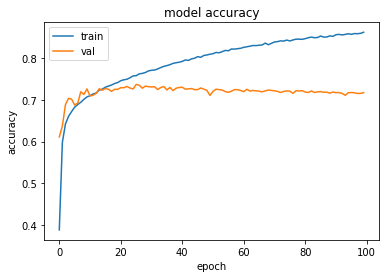

In [25]:
plt.plot(hist_3hl.history['acc'])
plt.plot(hist_3hl.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

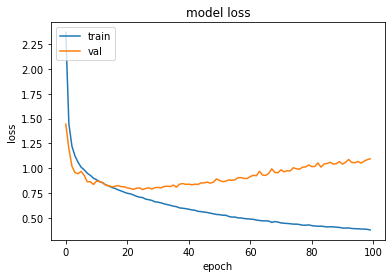

In [26]:
plt.plot(hist_3hl.history['loss'])
plt.plot(hist_3hl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

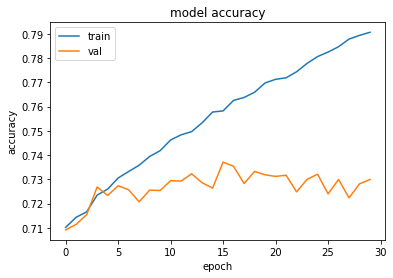

In [28]:
plt.plot(hist_3hl.history['acc'][10:40])
plt.plot(hist_3hl.history['val_acc'][10:40])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

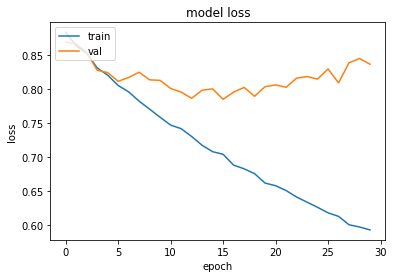

In [29]:
plt.plot(hist_3hl.history['loss'][10:40])
plt.plot(hist_3hl.history['val_loss'][10:40])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [36]:
start = datetime.now()
hist_3hl = model_3hl.fit(X, y, validation_split=0.25, epochs=60, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=350, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Train on 71755 samples, validate on 23919 samples
Epoch 1/60
 - 8s - loss: 1.9338 - acc: 0.4849 - val_loss: 1.2089 - val_acc: 0.6456
Epoch 2/60
 - 6s - loss: 1.2151 - acc: 0.6421 - val_loss: 0.9997 - val_acc: 0.6897
Epoch 3/60
 - 7s - loss: 1.0696 - acc: 0.6712 - val_loss: 0.9135 - val_acc: 0.7098
Epoch 4/60
 - 6s - loss: 0.9975 - acc: 0.6859 - val_loss: 0.9274 - val_acc: 0.6983
Epoch 5/60
 - 7s - loss: 0.9500 - acc: 0.6954 - val_loss: 0.8622 - val_acc: 0.7153
Epoch 6/60
 - 7s - loss: 0.9108 - acc: 0.7043 - val_loss: 0.8617 - val_acc: 0.7110
Epoch 7/60
 - 6s - loss: 0.8838 - acc: 0.7102 - val_loss: 0.8355 - val_acc: 0.7206
Epoch 8/60
 - 7s - loss: 0.8600 - acc: 0.7161 - val_loss: 0.8286 - val_acc: 0.7187
Epoch 9/60
 - 6s - loss: 0.8346 - acc: 0.7207 - val_loss: 0.8712 - val_acc: 0.6992
Epoch 10/60
 - 7s - loss: 0.8112 - acc: 0.7281 - val_loss: 0.8175 - val_acc: 0.7199
Epoch 11/60
 - 7s - loss: 0.7908 - acc: 0.7310 - val_loss: 0.8000 - val_acc: 0.7263
Epoch 12/60
 - 7s - loss: 0.7709 - 

'0:04:05.028675'

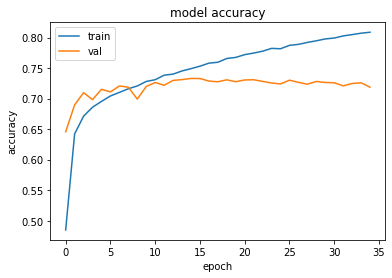

In [37]:
plt.plot(hist_3hl.history['acc'])
plt.plot(hist_3hl.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

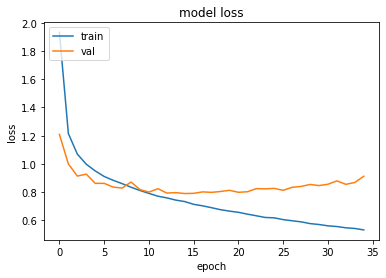

In [38]:
plt.plot(hist_3hl.history['loss'])
plt.plot(hist_3hl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
def create_model_3hl(nodes_l1=400, nodes_l2=200, nodes_l3=100, dropout_l1=0.2, dropout_l2=0.2, dropout_l3=0.2):
    model = Sequential()
    model.add(Dense(output_dim=nodes_l1, activation="relu", input_dim=len(X.columns)))
    model.add(Dropout(dropout_l1))
    model.add(Dense(output_dim=nodes_l2, activation="relu"))
    model.add(Dropout(dropout_l2))
    model.add(Dense(output_dim=nodes_l3, activation="relu"))
    model.add(Dropout(dropout_l3))
            
    model.add(Dense(output_dim=len(trip_types), activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [44]:
model_3hl = KerasClassifier(build_fn=create_model_3hl, epochs=70, batch_size=1000, verbose=2)

In [45]:
callbacks = [EarlyStopping(monitor="val_acc", patience=20), 
             ModelCheckpoint(filepath="best_model.h5", monitor="val_acc", save_best_only=True)]

In [46]:
start = datetime.now()
hist_3hl = model_3hl.fit(X, y, validation_split=0.25, epochs=60, batch_size=1000, callbacks=callbacks)
end = datetime.now()
str(end-start)

C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", input_dim=350, units=400)`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=200)`
  """
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=100)`
  import sys
C:\Users\Xiuquan\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=38)`
  # Remove the CWD from sys.path while we load stuff.


Train on 71755 samples, validate on 23919 samples
Epoch 1/60
 - 8s - loss: 2.0256 - acc: 0.4687 - val_loss: 1.2208 - val_acc: 0.6563
Epoch 2/60
 - 6s - loss: 1.2724 - acc: 0.6356 - val_loss: 1.0121 - val_acc: 0.6982
Epoch 3/60
 - 6s - loss: 1.1192 - acc: 0.6647 - val_loss: 0.9800 - val_acc: 0.6895
Epoch 4/60
 - 7s - loss: 1.0416 - acc: 0.6795 - val_loss: 0.9108 - val_acc: 0.7131
Epoch 5/60
 - 6s - loss: 0.9845 - acc: 0.6933 - val_loss: 0.8809 - val_acc: 0.7178
Epoch 6/60
 - 6s - loss: 0.9473 - acc: 0.6999 - val_loss: 0.8855 - val_acc: 0.7085
Epoch 7/60
 - 6s - loss: 0.9155 - acc: 0.7083 - val_loss: 0.8501 - val_acc: 0.7233
Epoch 8/60
 - 6s - loss: 0.8924 - acc: 0.7112 - val_loss: 0.8468 - val_acc: 0.7224
Epoch 9/60
 - 6s - loss: 0.8655 - acc: 0.7184 - val_loss: 0.8390 - val_acc: 0.7239
Epoch 10/60
 - 6s - loss: 0.8481 - acc: 0.7233 - val_loss: 0.8178 - val_acc: 0.7288
Epoch 11/60
 - 6s - loss: 0.8276 - acc: 0.7278 - val_loss: 0.8103 - val_acc: 0.7312
Epoch 12/60
 - 6s - loss: 0.8062 - 

'0:04:52.746045'

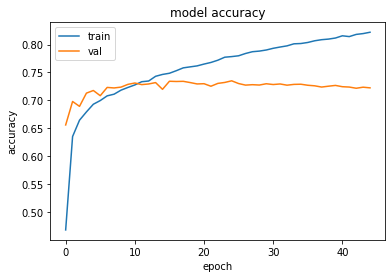

In [47]:
plt.plot(hist_3hl.history['acc'])
plt.plot(hist_3hl.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

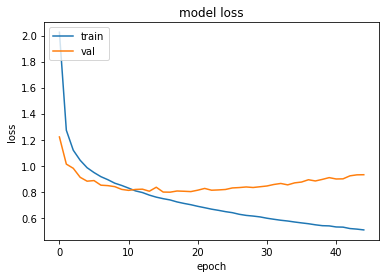

In [48]:
plt.plot(hist_3hl.history['loss'])
plt.plot(hist_3hl.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

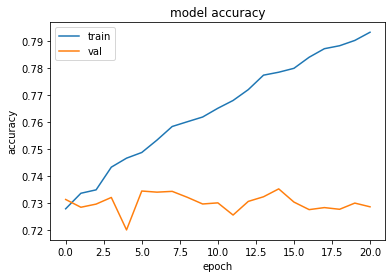

In [50]:
plt.plot(hist_3hl.history['acc'][10:31])
plt.plot(hist_3hl.history['val_acc'][10:31])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

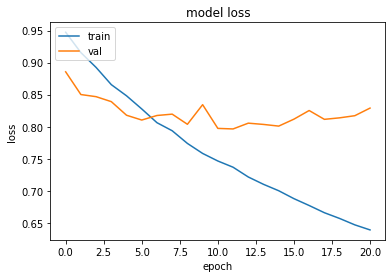

In [51]:
plt.plot(hist_3hl.history['loss'][5:26])
plt.plot(hist_3hl.history['val_loss'][5:26])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
min(hist_3hl.history['val_loss'])

0.7964553129185082